In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"pr1266","key":"40895bab32871950c170d08e5469e676"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ------  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                     9KB  2022-10-06 08:55:25           6490        210  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset              11KB  2022-09-30 04:05:11           5243        172  1.0              
akshaydattatraykhare/car-details-dataset                        Car Details Dataset                                 56KB  2022-10-21 06:11:56           1174         30  1.0              
whena

In [4]:
# import necessary packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [5]:
# here we extract downloaded dataset:
from zipfile import ZipFile
data_path = 'lung-and-colon-cancer-histopa\
thological-images.zip'
  
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [6]:
# as mentioned in docs, we are going to classify lung images not colon
# so there is 3 classes to identify:
path = '/content/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_n', 'lung_scc', 'lung_aca']

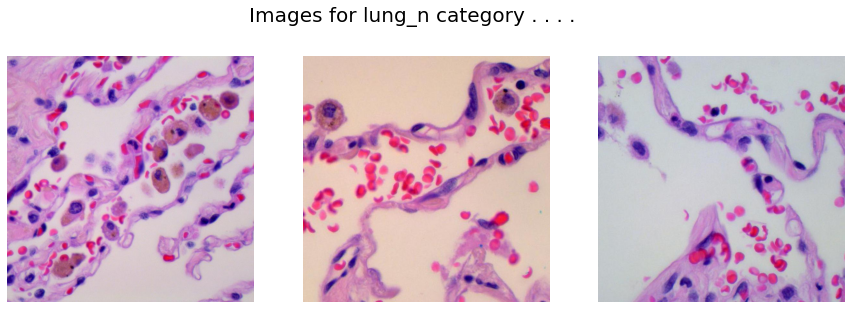

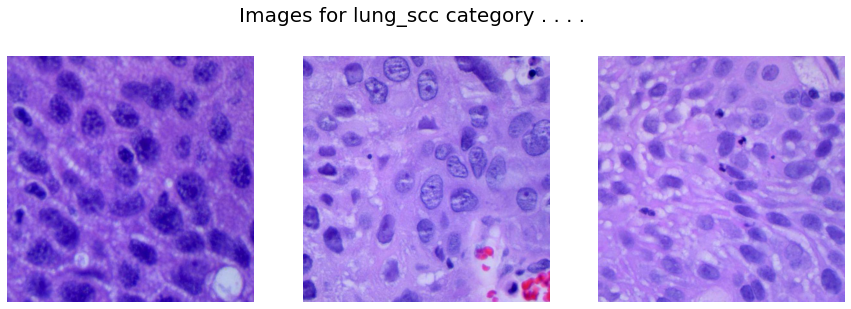

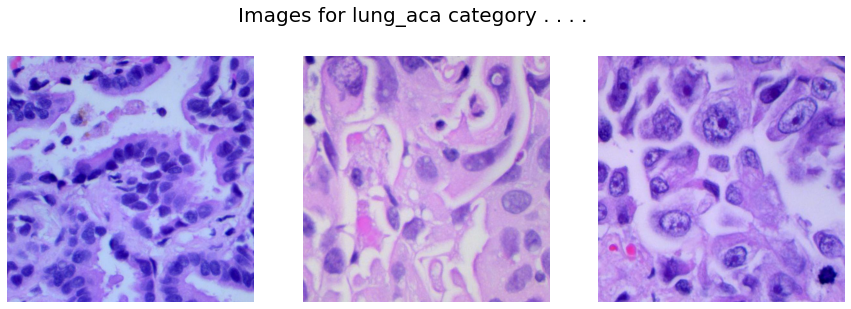

In [7]:
# in this cell, we iterate over classes folders and plot 3 images of each classes:
path = '/content/lung_colon_image_set/lung_image_sets'
  
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
  
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', 
                 fontsize = 20)
  
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [8]:
# declare our hyperparameters:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [9]:
# in this phase, we iterate over dataset folders,
# and load images into our features array x and also save the
# index of current folder as class label into our target array y:
# we load images using OpenCV
# as mentioned in provided documentation, we resize the images
# to 256 * 256 pixels as Inception Net standard input size
# finally, we convert labels into one hot encoding to be suitable for cross entropy loss function:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
  
  for image in images:
    img = cv2.imread(image)
      
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
  
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [10]:
# now, we split our data into train and test datasets with a 0.2 dataset split factor
X_train, X_test, Y_train, Y_test = train_test_split(
  X, one_hot_encoded_Y, test_size =SPLIT, random_state = 2022)
print(X_train.shape, X_test.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [11]:
# now we are loading our pretrained network that implemented in keras package
# this model has been trained on ImageNet dataset.
# the paper of Inception Net is attached in our document.
pre_trained_model = InceptionV3(input_shape = (IMG_SIZE, IMG_SIZE, 3), weights = 'imagenet', include_top = False)
# print(len(pre_trained_model.layers))

#! in this line we are going to freeze our trainable parameters
#! of our feature extractor backbone:
for layer in pre_trained_model.layers:
  layer.trainable = False

# in this section, we save last feature extraction layer output
# now, we must create a classification section for out pretrained model
# to make it classify input data into our classes:
last_layer = pre_trained_model.get_layer('mixed7')
# print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# we flat output of last layer and create a single dimentional vector from its data
x = layers.Flatten()(last_output)
# here we create two fully connected layers with 256 and 128 neurons
# also to prevent overfit, we use batch normalization and dropout normalization with drop probability of 0.3
x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
# our output layer uses a softmax activation function to create one hot encoded output
output = layers.Dense(3, activation='softmax')(x)
# here we connect our pretrained feature extractor to classification submodel:
model = keras.Model(pre_trained_model.input, output)

In [12]:
# here we create some callback functions to improve our training phase
# it contains Early Stoping on validation accuracy, Learning Rate decay during training
# and stoping training when val accuracy is more than 0.9 percent:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True
  
es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
  
lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

In [13]:
# now we compile our model, our loss function in categorical cross entropy due to classify output to one of our 3 classes
# we use Adam as optimizer and accuracy as validation metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# everything is ready to start training model,
# we save history of training includeing loss, val_loss, accuracy and val_accuracy into history variable to plot it
history = model.fit(X_train, Y_train, validation_split=0.33, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, callbacks = [es, lr, myCallback()])

Epoch 1/10
126/126 [==============================] - 43s 245ms/step - loss: 0.4081 - accuracy: 0.8338 - val_loss: 1.6544 - val_accuracy: 0.5776 - lr: 0.0010
Epoch 2/10
126/126 [==============================] - 28s 220ms/step - loss: 0.2520 - accuracy: 0.9015 - val_loss: 0.4549 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 3/10
126/126 [==============================] - 28s 224ms/step - loss: 0.1899 - accuracy: 0.9264 - val_loss: 1.3048 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 4/10
126/126 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9356
 Validation accuracy has reached upto 90%      so, stopping further training.
126/126 [==============================] - 27s 218ms/step - loss: 0.1637 - accuracy: 0.9356 - val_loss: 0.2456 - val_accuracy: 0.9013 - lr: 0.0010


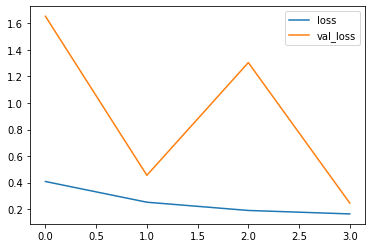

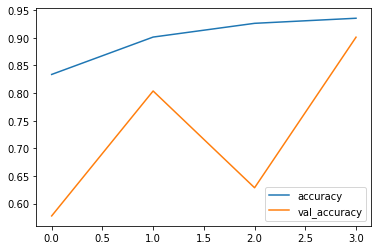

In [14]:
#! now we plot our metrics that we saved during training phase:
# first we convert it into a pandas DataFrame and then plot it using matplotlib package:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [15]:
# here we predict the test data and evaluate it using correct ground truth labels:
Y_pred = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.confusion_matrix(Y_test, Y_pred))
#! here we evaluate prediction results:
#! in this table you can see precision, recall, accuracy f1 score for each class separately
print(metrics.classification_report(Y_test, Y_pred, target_names=classes))

94/94 [==============================] - 9s 78ms/step
[[976   0  11]
 [  8 776 193]
 [ 36  18 982]]
              precision    recall  f1-score   support

      lung_n       0.96      0.99      0.97       987
    lung_scc       0.98      0.79      0.88       977
    lung_aca       0.83      0.95      0.88      1036

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000

